# Modeling the Data with Word2Vec

In [1]:
# import libraries
import os
import string
import sys
from collections import Counter
import re

import numpy as np
import pandas as pd

# languange processing imports
import nltk
from gensim.corpora import Dictionary

# preprocessing imports
from sklearn.preprocessing import LabelEncoder

# model imports
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# hyperparameter training imports
from sklearn.model_selection import GridSearchCV

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load the data
full_df = pd.read_csv('data/clinic_train_data.csv', index_col=0)

In [3]:
# drop all but text and label data
df = full_df[['readmission','text']].copy()
df.columns = ['label', 'text']
df = df.reset_index(drop = True)
df.head(3)

,label,text
0,0,Admission Date: [**2198-6-12**] ...
1,0,Admission Date: [**2153-9-2**] D...
2,0,Admission Date: [**2123-3-1**] D...


In [4]:
# split data into training and validation set
df_trn, df_val = train_test_split(df, 
                                  stratify = df['label'], 
                                  test_size = 0.33, 
                                  random_state = 42)

In [5]:
df_trn.shape, df_val.shape

((23971, 2), (11808, 2))

In [6]:
print(df_trn.label.value_counts())
print(df_val.label.value_counts())

0    22528
1     1443
Name: label, dtype: int64
0    11097
1      711
Name: label, dtype: int64


In [7]:
doc_lengths = np.array(list(map(len, df_trn.text.str.split(' '))))

print("The average number of words in a document is: {}.".format(np.mean(doc_lengths)))
print("The minimum number of words in a document is: {}.".format(min(doc_lengths)))
print("The maximum number of words in a document is: {}.".format(max(doc_lengths)))

The average number of words in a document is: 3335.019231571482.
The minimum number of words in a document is: 2.
The maximum number of words in a document is: 281365.


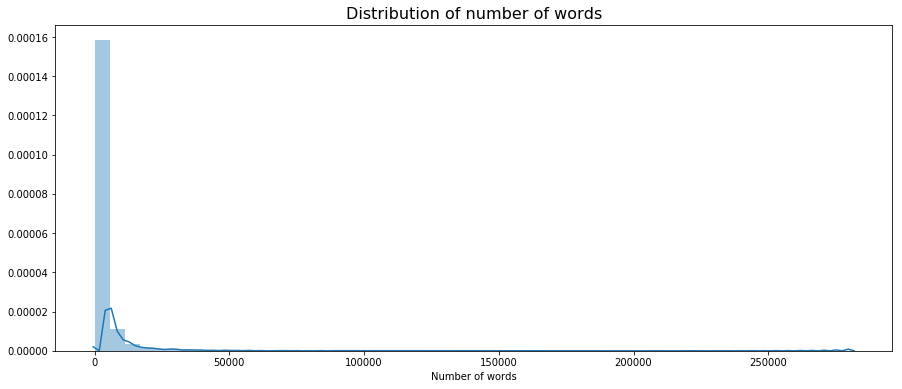

In [8]:
fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(doc_lengths, bins=50, ax=ax)

In [9]:
print("There are {} documents with over 10000 words.".format(sum(doc_lengths > 10000)))

There are 1253 documents with over 10000 words.


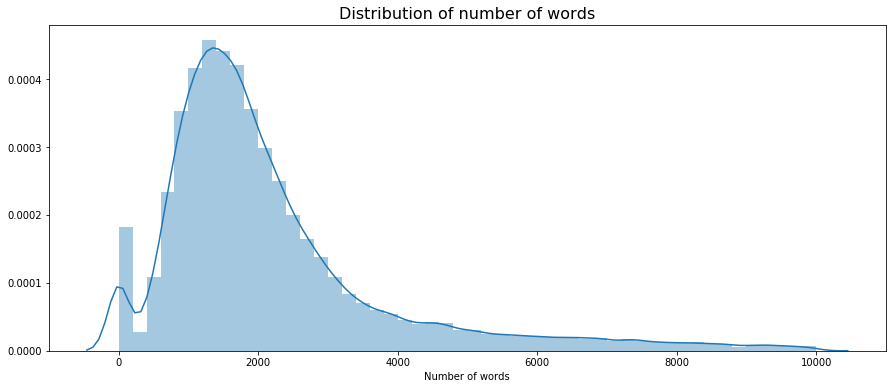

In [10]:
fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(doc_lengths[doc_lengths <= 10000], bins=50, ax=ax)
plt.savefig('img/word_count_distro.png')

In [11]:
print("There are {} documents with 5 words or less.".format(sum(doc_lengths <= 5)))

There are 819 documents with 5 words or less.


In [12]:
df_trn[doc_lengths == 2].text.value_counts() # 819 docs with just 2 spaces and no text

     819
Name: text, dtype: int64

In [13]:
# drop empty text
df_trn_clean = df_trn[doc_lengths > 2].copy()

In [14]:
def get_good_tokens(sentence):
    replaced_punctation = list(map(lambda token: re.sub('[^0-9A-Za-z!?]+', '', token), sentence))
    removed_punctation = list(filter(lambda token: token, replaced_punctation))
    return removed_punctation

def w2v_preprocessing(df):
    """ All the preprocessing steps for word2vec are done in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    df['text'] = df.text.str.lower()
    df['document_sentences'] = df.text.str.split('.')  # split texts into individual sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(nltk.word_tokenize, sentences)),
                                         df.document_sentences))  # tokenize sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(get_good_tokens, sentences)),
                                         df.tokenized_sentences))  # remove unwanted characters
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(filter(lambda lst: lst, sentences)),
                                         df.tokenized_sentences))  # remove empty lists

w2v_preprocessing(df_trn_clean)

In [15]:
def lda_get_good_tokens(df):
    df['text'] = df.text.str.lower()
    df['tokenized_text'] = list(map(nltk.word_tokenize, df.text))
    df['tokenized_text'] = list(map(get_good_tokens, df.tokenized_text))

lda_get_good_tokens(df_trn_clean)

In [16]:
# compute word frequencies
tokenized_only_dict = Counter(np.concatenate(df_trn_clean.tokenized_text.values))
tokenized_only_df = pd.DataFrame.from_dict(tokenized_only_dict, orient='index')
tokenized_only_df.rename(columns={0: 'count'}, inplace=True)
tokenized_only_df.sort_values('count', ascending=False, inplace=True)

Text(0.5, 1.0, 'Word Frequencies')

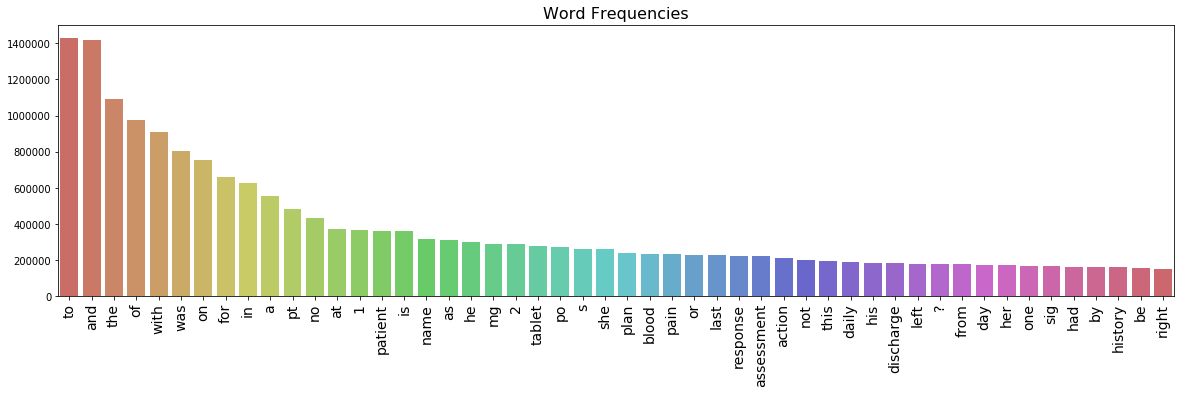

In [17]:
def word_frequency_barplot(df, nr_top_words=50):
    """ df should have a column named count.
    """
    fig, ax = plt.subplots(1,1,figsize=(20,5))

    sns.barplot(list(range(nr_top_words)), df['count'].values[:nr_top_words], palette='hls', ax=ax)

    ax.set_xticks(list(range(nr_top_words)))
    ax.set_xticklabels(df.index[:nr_top_words], fontsize=14, rotation=90)
    return ax
    
ax = word_frequency_barplot(tokenized_only_df)
ax.set_title("Word Frequencies", fontsize=16)

In [18]:
# define stopwords
stopwords = nltk.corpus.stopwords.words('english')

# remove stopwords
df_trn_clean['stopwords_removed'] = list(map(lambda doc:
                                       [word for word in doc if word not in stopwords],
                                       df_trn_clean['tokenized_text']))

In [19]:
def stem_words(df):
    lemm = nltk.stem.WordNetLemmatizer()
    df['lemmatized_text'] = list(map(lambda sentence:
                                     list(map(lemm.lemmatize, sentence)),
                                     df.stopwords_removed))

    p_stemmer = nltk.stem.porter.PorterStemmer()
    df['stemmed_text'] = list(map(lambda sentence:
                                  list(map(p_stemmer.stem, sentence)),
                                  df.lemmatized_text))

stem_words(df_trn_clean)

In [20]:
# create a dictionary for the model
dictionary = Dictionary(documents=df_trn_clean.stemmed_text.values)

print("Found {} words.".format(len(dictionary.values())))

Found 334049 words.


In [21]:
# filter words that are contained in at least 3 docs
# but no more than 80% of docs
dictionary.filter_extremes(no_above=0.8, no_below=3)

dictionary.compactify()  # Reindexes the remaining words after filtering
print("Left with {} words.".format(len(dictionary.values())))

Left with 100000 words.


In [22]:
#Make a BOW for every document
def document_to_bow(df):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stemmed_text))
    
document_to_bow(df_trn_clean)

In [23]:
# combine preprocessing into one function for later use on test data
def lda_preprocessing(df):
    """ All the preprocessing steps for LDA are combined in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    lda_get_good_tokens(df)
    remove_stopwords(df)
    stem_words(df)
    document_to_bow(df)

In [24]:
# visualize processed word frequencies
cleansed_words_df = pd.DataFrame.from_dict(dictionary.token2id, orient='index')
cleansed_words_df.rename(columns={0: 'id'}, inplace=True)

cleansed_words_df['count'] = list(map(lambda id_: dictionary.dfs.get(id_), cleansed_words_df.id))
del cleansed_words_df['id']

cleansed_words_df.sort_values('count', ascending=False, inplace=True)

Text(0.5, 1.0, 'Document Frequencies (Number of documents a word appears in)')

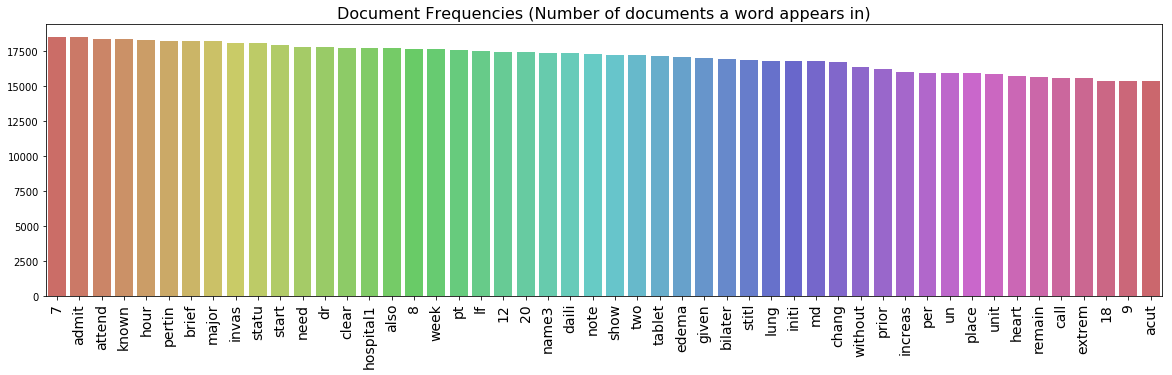

In [25]:
ax = word_frequency_barplot(cleansed_words_df)
ax.set_title("Document Frequencies (Number of documents a word appears in)", fontsize=16)

In [26]:
# explore word frequencies in readmit vs non
readmit_words = list(np.concatenate(df_trn_clean.loc[df_trn_clean.label == 1, 'stemmed_text'].values))
no_readmit_words = list(np.concatenate(df_trn_clean.loc[df_trn_clean.label == 0, 'stemmed_text'].values))

readmit_word_freqs = {word: readmit_words.count(word) for word in cleansed_words_df.index[:50]}
no_readmit_word_freqs = {word: no_readmit_words.count(word) for word in cleansed_words_df.index[:50]}

In [27]:
frequencies_df = pd.DataFrame(index=cleansed_words_df.index[:50])

# prep for stacked bar chart
frequencies_df['read_freq'] = list(map(lambda word:
                                      readmit_word_freqs[word],
                                      frequencies_df.index))
frequencies_df['noread_freq'] = list(map(lambda word:
                                          readmit_word_freqs[word] + no_readmit_word_freqs[word],
                                          frequencies_df.index))

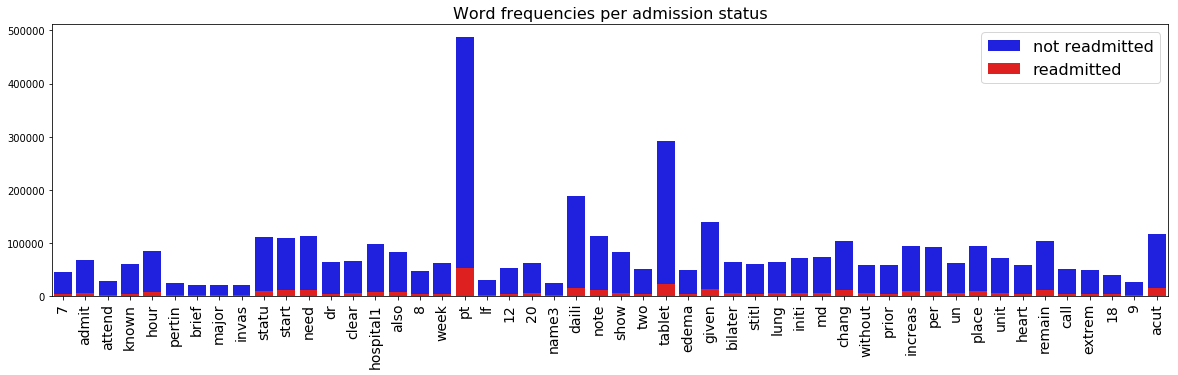

In [28]:
fig, ax = plt.subplots(1,1,figsize=(20,5))

nr_top_words = len(frequencies_df)
nrs = list(range(nr_top_words))
sns.barplot(nrs, frequencies_df['noread_freq'].values, color='b', ax=ax, label="not readmitted")
sns.barplot(nrs, frequencies_df['read_freq'].values, color='r', ax=ax, label="readmitted")

ax.set_title("Word frequencies per admission status", fontsize=16)
ax.legend(prop={'size': 16})
ax.set_xticks(nrs)
ax.set_xticklabels(frequencies_df.index, fontsize=14, rotation=90);

In [29]:
corpus = df_trn_clean.bow

In [30]:
%%time
num_topics = 150

#A multicore approach to decrease training time
LDAmodel = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        workers=8,
                        chunksize=4000,
                        passes=7,
                        alpha='asymmetric')

/opt/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:1030: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


CPU times: user 45min 43s, sys: 1min 18s, total: 47min 2s
Wall time: 36min 55s


In [32]:
def document_to_lda_features(lda_model, document):
    """ Transforms a bag of words document to features.
    It returns the proportion of how much each topic was
    present in the document.
    """
    topic_importances = LDAmodel.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

df_trn_clean['lda_features'] = list(map(lambda doc:
                                      document_to_lda_features(LDAmodel, doc),
                                      corpus))

In [33]:
readmit_topic_distribution = df_trn_clean.loc[df_trn_clean.label == 1, 'lda_features'].mean()
noreadmit_topic_distribution = df_trn_clean.loc[df_trn_clean.label == 0, 'lda_features'].mean()

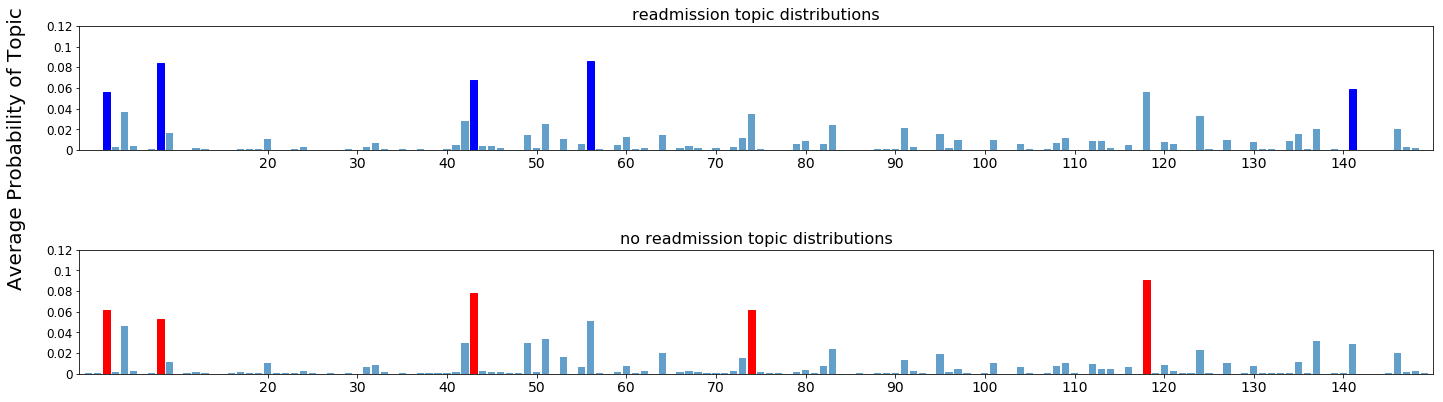

In [34]:
fig, [ax1,ax2] = plt.subplots(2,1,figsize=(20,8))

nr_top_bars = 5

ax1.set_title("readmission topic distributions", fontsize=16)
ax2.set_title("no readmission topic distributions", fontsize=16)

fig.subplots_adjust(top=0.3)  
ax1.text(-8, -0.135, "Average Probability of Topic", fontsize=20, ha="center", va="bottom",
         rotation="vertical")

for ax, distribution, color in zip([ax1,ax2],
                                   [readmit_topic_distribution, noreadmit_topic_distribution],
                                   ['b', 'r']):
    
    # Individual distribution barplots
    ax.bar(range(len(distribution)), distribution, alpha=0.7)
    rects = ax.patches
    for i in np.argsort(distribution)[-nr_top_bars:]:
        rects[i].set_color(color)
        rects[i].set_alpha(1)
        
    # General plotting adjustments
    ax.set_xlim(-1, 150)
    ax.set_xticks(range(20,149,10))
    ax.set_xticklabels(range(20,149,10), fontsize=14)
    ax.set_ylim(0,0.12)
    ax.set_yticks([0,0.02,0.04,0.06,0.08,0.1,0.12])
    ax.set_yticklabels([0,0.02,0.04,0.06,0.08,0.1, 0.12], fontsize=12)
    
fig.tight_layout(h_pad=3.)
plt.savefig('img/topic_distro.png')

In [35]:
def get_topic_top_words(lda_model, topic_id, nr_top_words=5):
    """ Returns the top words for topic_id from lda_model.
    """
    id_tuples = lda_model.get_topic_terms(topic_id, topn=nr_top_words)
    word_ids = np.array(id_tuples)[:,0]
    words = map(lambda id_: lda_model.id2word[id_], word_ids)
    return words

In [36]:
for status, distribution in zip(['readmitted','not readmitted'], [readmit_topic_distribution, noreadmit_topic_distribution]):
    print("Looking up top words from top topics from {} patients.".format(status))
    for x in sorted(np.argsort(distribution)[-5:]):
        top_words = get_topic_top_words(LDAmodel, x)
        print("For topic {}, the top words are: {}.".format(x, ", ".join(top_words)))
    print("")

Looking up top words from top topics from readmitted patients.
For topic 2, the top words are: tablet, daili, sig, cardiac, ventricular.
For topic 8, the top words are: tablet, daili, sig, hospital1, pt.
For topic 43, the top words are: statu, unit, show, number, also.
For topic 56, the top words are: tablet, sig, daili, need, capsul.
For topic 141, the top words are: daili, tablet, cultur, sig, neg.

Looking up top words from top topics from not readmitted patients.
For topic 2, the top words are: tablet, daili, sig, cardiac, ventricular.
For topic 8, the top words are: tablet, daili, sig, hospital1, pt.
For topic 43, the top words are: statu, unit, show, number, also.
For topic 74, the top words are: tablet, daili, sig, disp, refil.
For topic 118, the top words are: arteri, coronari, qd, postop, statu.



## Word2Vec

In [37]:
sentences = []
for sentence_group in df_trn_clean.tokenized_sentences:
    sentences.extend(sentence_group)

print("Number of sentences: {}.".format(len(sentences)))
print("Number of texts: {}.".format(len(df_trn_clean)))

Number of sentences: 5956092.
Number of texts: 23152.


In [38]:
%%time
# Set values for various parameters
num_features = 200    # Word vector dimensionality
min_word_count = 3    # Minimum word count
num_workers = 8       # Number of threads to run in parallel
context = 6           # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model
W2Vmodel = Word2Vec(sentences=sentences,
                    sg=1,
                    hs=0,
                    workers=num_workers,
                    size=num_features,
                    min_count=min_word_count,
                    window=context,
                    sample=downsampling,
                    negative=5,
                    iter=6)

CPU times: user 1h 35min 54s, sys: 11.2 s, total: 1h 36min 5s
Wall time: 12min 35s


In [39]:
def get_w2v_features(w2v_model, sentence_group):
    """ Transform a sentence_group (containing multiple lists
    of words) into a feature vector. It averages out all the
    word vectors of the sentence_group.
    """
    words = np.concatenate(sentence_group)  # words in text
    index2word_set = set(w2v_model.wv.vocab.keys())  # words known to model
    
    featureVec = np.zeros(w2v_model.vector_size, dtype="float32")
    
    # Initialize a counter for number of words in the admission notes
    nwords = 0
    # Loop over each word in the notes and, if it is in the model's vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            featureVec = np.add(featureVec, w2v_model[word])
            nwords += 1.
            
    # Divide the result by the number of words to get the average
    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

df_trn_clean['w2v_features'] = list(map(lambda sen_group:
                                      get_w2v_features(W2Vmodel, sen_group),
                                      df_trn_clean.tokenized_sentences))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


In [40]:
readmit_w2v_distribution = df_trn_clean.loc[df_trn_clean.label == 1, 'w2v_features'].mean()
noreadmit_w2v_distribution = df_trn_clean.loc[df_trn_clean.label == 0, 'w2v_features'].mean()

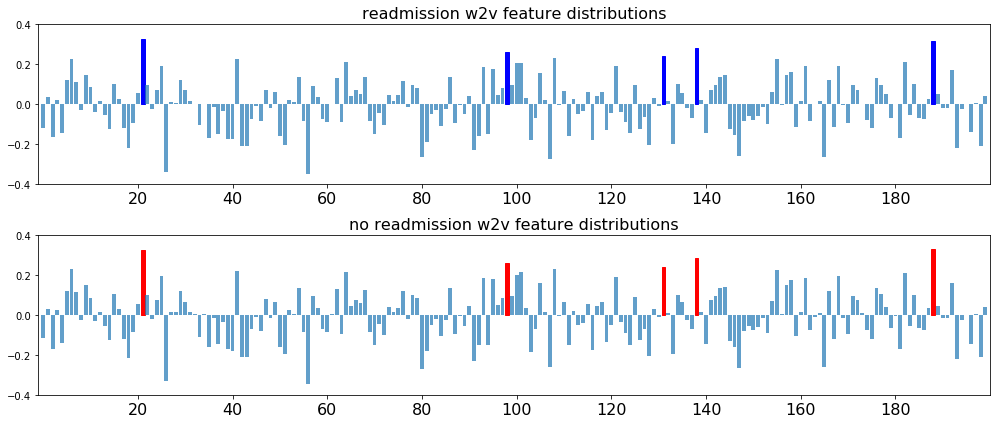

In [42]:
fig, [ax1,ax2] = plt.subplots(2,1,figsize=(14,6))

nr_top_bars = 5

ax1.set_title("readmission w2v feature distributions", fontsize=16)
ax2.set_title("no readmission w2v feature distributions", fontsize=16)
#ax2.text(-8, 0.4, "Average feature vectors", fontsize=18, ha="center", va="bottom", rotation="vertical")

for ax, distribution, color in zip([ax1,ax2], [readmit_w2v_distribution, noreadmit_w2v_distribution], ['b','r']):
    # Individual distribution barplots
    ax.bar(range(len(distribution)), distribution, alpha=0.7)
    rects = ax.patches
    for i in np.argsort(distribution)[-nr_top_bars:]:
        rects[i].set_color(color)
        rects[i].set_alpha(1)
    # General plotting adjustments
    ax.set_xlim(-1, 200)
    ax.set_xticks(range(20,199,20))
    ax.set_xticklabels(range(20,199,20), fontsize=16)
    ax.set_ylim(-0.4,0.4)

fig.tight_layout()
plt.savefig('img/w2v_feature_distro.png')

In [43]:
label_encoder = LabelEncoder()

label_encoder.fit(df_trn_clean.label)
df_trn_clean['label'] = label_encoder.transform(df_trn_clean.label)

In [93]:
def get_cross_validated_model(model, param_grid, X, y, nr_folds=5):
    """ Trains a model by doing a grid search combined with cross validation.
    args:
        model: your model
        param_grid: dict of parameter values for the grid search
    returns:
        Model trained on entire dataset with hyperparameters chosen from best results in the grid search.
    """
    # train the model (since the evaluation is based on the logloss, we'll use neg_log_loss here)
    grid_cv = GridSearchCV(model, param_grid=param_grid, scoring='roc_auc', 
                           cv=nr_folds, n_jobs=-1, verbose=True, return_train_score=True)
    best_model = grid_cv.fit(X, y)
    # show top models with parameter values
    result_df = pd.DataFrame(best_model.cv_results_)
    show_columns = ['mean_test_score', 'mean_train_score', 'rank_test_score']
    for col in result_df.columns:
        if col.startswith('param_'):
            show_columns.append(col)
    display(result_df[show_columns].sort_values(by='rank_test_score').head())
    return best_model

In [45]:
# transform train_data['lda_features'] and train_data['w2v_features'] 
X_train_lda = np.array(list(map(np.array, df_trn_clean.lda_features)))
X_train_w2v = np.array(list(map(np.array, df_trn_clean.w2v_features)))

In [84]:
# combine lda and w2v
X_train_combined = np.append(X_train_lda, X_train_w2v, axis=1)

In [47]:
# store all models in a dictionary
models = dict()

In [73]:
# LDA features only
lr = LogisticRegression()

param_grid = {'penalty': ['l1', 'l2']}

best_lr_lda = get_cross_validated_model(lr, param_grid, X_train_lda, df_trn_clean.label)

models['best_lr_lda'] = best_lr_lda

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.0s finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need tr

,mean_test_score,mean_train_score,rank_test_score,param_penalty
0,0.663349,0.676209,1,l1
1,0.661681,0.679580,2,l2


In [80]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(shrink=0.7)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Confusion matrix, without normalization
[[21725     7]
 [ 1410    10]]


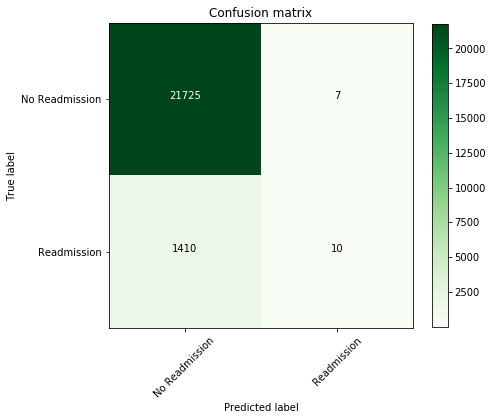

In [81]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import itertools

lr_lda = LogisticRegression(penalty='l1', solver='liblinear')
y_pred = cross_val_predict(lr_lda, X_train_lda, df_trn_clean.label, cv=5)


# Compute confusion matrix
conf_mat = confusion_matrix(df_trn_clean.label, y_pred)
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(7,7))
plot_confusion_matrix(conf_mat, classes=['No Readmission','Readmission'],
                      title='Confusion matrix')

plt.show()

In [82]:
# Word2Vec features only
lr = LogisticRegression()

param_grid = {'penalty': ['l1', 'l2']}

best_lr_w2v = get_cross_validated_model(lr, param_grid, X_train_w2v, df_trn_clean.label)

models['best_lr_w2v'] = best_lr_w2v

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   10.4s finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need tr

,mean_test_score,mean_train_score,rank_test_score,param_penalty
1,0.704511,0.717488,1,l2
0,0.702773,0.716849,2,l1


Confusion matrix, without normalization
[[21732     0]
 [ 1420     0]]


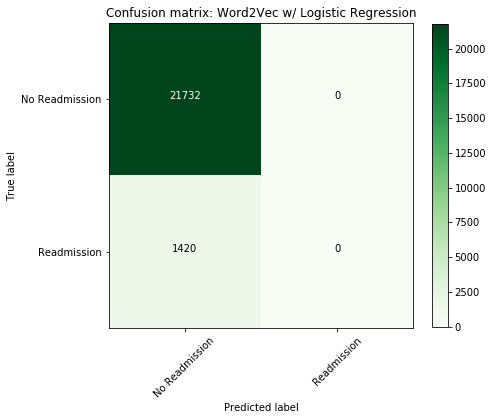

In [87]:
lr_w2v = LogisticRegression(penalty='l2', solver='liblinear')
y_pred = cross_val_predict(lr_w2v, X_train_w2v, df_trn_clean.label, cv=5)


# Compute confusion matrix
conf_mat = confusion_matrix(df_trn_clean.label, y_pred)
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(7,7))
plot_confusion_matrix(conf_mat, classes=['No Readmission','Readmission'],
                      title='Confusion matrix: Word2Vec w/ Logistic Regression')

plt.show()

In [85]:
# LDA and Word2Vec combined
lr = LogisticRegression()

param_grid = {'penalty': ['l1', 'l2']}

best_lr_combined = get_cross_validated_model(lr, param_grid, X_train_combined, df_trn_clean.label)

models['best_lr_combined'] = best_lr_combined

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    9.3s finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need tr

,mean_test_score,mean_train_score,rank_test_score,param_penalty
1,0.707772,0.731607,1,l2
0,0.707662,0.728305,2,l1


Confusion matrix, without normalization
[[21729     3]
 [ 1415     5]]


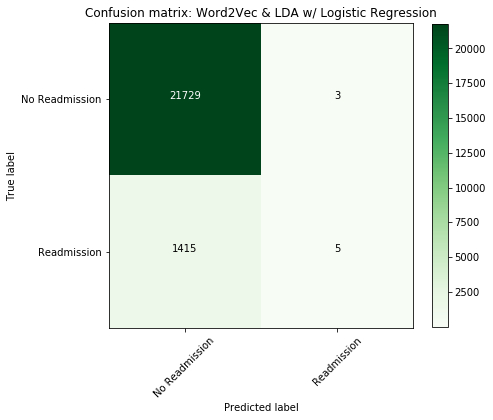

In [88]:
lr_comb = LogisticRegression(penalty='l2', solver='liblinear')
y_pred = cross_val_predict(lr_comb, X_train_combined, df_trn_clean.label, cv=5)


# Compute confusion matrix
conf_mat = confusion_matrix(df_trn_clean.label, y_pred)
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(7,7))
plot_confusion_matrix(conf_mat, classes=['No Readmission','Readmission'],
                      title='Confusion matrix: Word2Vec & LDA w/ Logistic Regression')

plt.show()

### Random Under-sampling

In [89]:
from sklearn.utils import resample

# Separate majority and minority classes
df_noreadmit = df_trn_clean[df_trn_clean.label==0]
df_readmit = df_trn_clean[df_trn_clean.label==1]
 
# Downsample majority class
df_noreadmit_undersampled = resample(df_noreadmit, 
                           replace=False,
                           n_samples=len(df_readmit),
                           random_state=42)
 
# Combine minority class with downsampled majority class
df_undersampled = pd.concat([df_noreadmit_undersampled, df_readmit])
 
# Display new class counts
df_undersampled.label.value_counts()

1    1420
0    1420
Name: label, dtype: int64

In [90]:
# transform train_data['lda_features'] and train_data['w2v_features'] 
X_train_lda_rus = np.array(list(map(np.array, df_undersampled.lda_features)))
X_train_w2v_rus = np.array(list(map(np.array, df_undersampled.w2v_features)))
X_train_combined_rus = np.append(X_train_lda_rus, X_train_w2v_rus, axis=1)

In [91]:
# LDA features only
lr = LogisticRegression()

param_grid = {'penalty': ['l1', 'l2']}

best_lr_lda_rus = get_cross_validated_model(lr, param_grid, X_train_lda_rus, df_undersampled.label)

models['best_lr_lda_rus'] = best_lr_lda_rus

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.4s finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need tr

,mean_test_score,mean_train_score,rank_test_score,param_penalty
1,0.644401,0.679087,1,l2
0,0.644101,0.670606,2,l1


Confusion matrix, without normalization
[[21731     1]
 [ 1414     6]]


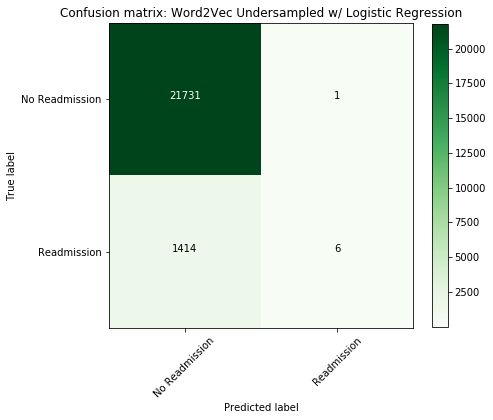

In [92]:
lr_rus_lda = LogisticRegression(penalty='l2', solver='liblinear')
y_pred = cross_val_predict(lr_rus_lda, X_train_lda, df_trn_clean.label, cv=5)


# Compute confusion matrix
conf_mat = confusion_matrix(df_trn_clean.label, y_pred)
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(7,7))
plot_confusion_matrix(conf_mat, classes=['No Readmission','Readmission'],
                      title='Confusion matrix: LDA Undersampled w/ Logistic Regression')

plt.show()

In [94]:
# Word2Vec features only
lr = LogisticRegression()

param_grid = {'penalty': ['l1', 'l2']}

best_lr_w2v_rus = get_cross_validated_model(lr, param_grid, X_train_w2v_rus, df_undersampled.label)

models['best_lr_w2v_rus'] = best_lr_w2v_rus

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.6s finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,mean_test_score,mean_train_score,rank_test_score,param_penalty
1,0.692402,0.714824,1,l2
0,0.691735,0.714313,2,l1


Confusion matrix, without normalization
[[879 541]
 [480 940]]


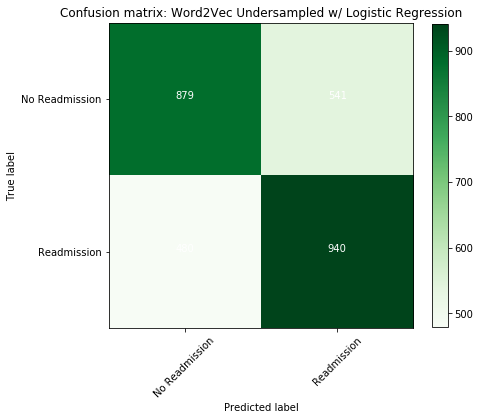

In [98]:
lr_rus_w2v = LogisticRegression(penalty='l2', solver='liblinear')
y_pred = cross_val_predict(lr_rus_w2v, X_train_w2v_rus, df_undersampled.label, cv=5)


# Compute confusion matrix
conf_mat = confusion_matrix(df_undersampled.label, y_pred)
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(7,7))
plot_confusion_matrix(conf_mat, classes=['No Readmission','Readmission'],
                      title='Confusion matrix: Word2Vec Undersampled w/ Logistic Regression')

plt.show()

In [99]:
# LDA and Word2Vec combined
lr = LogisticRegression()

param_grid = {'penalty': ['l1', 'l2']}

best_lr_combined_rus = get_cross_validated_model(lr, param_grid, X_train_combined_rus, df_undersampled.label)

models['best_lr_combined_rus'] = best_lr_combined_rus

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.8s finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,mean_test_score,mean_train_score,rank_test_score,param_penalty
1,0.690503,0.732320,1,l2
0,0.685529,0.719861,2,l1


Confusion matrix, without normalization
[[912 508]
 [522 898]]


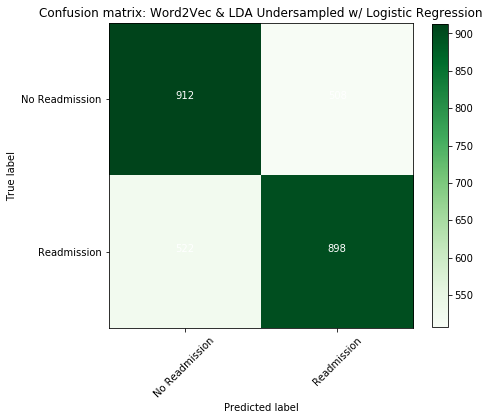

In [101]:
lr_rus_comb = LogisticRegression(penalty='l2', solver='liblinear')
y_pred = cross_val_predict(lr_rus_comb, X_train_combined_rus, df_undersampled.label, cv=5)


# Compute confusion matrix
conf_mat = confusion_matrix(df_undersampled.label, y_pred)
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(7,7))
plot_confusion_matrix(conf_mat, classes=['No Readmission','Readmission'],
                      title='Confusion matrix: Word2Vec & LDA Undersampled w/ Logistic Regression')

plt.show()

In [102]:
for name, model in models.items():
    print("Model {} has a test score of: {:0.4f}".format(name, float(model.best_score_)))

Model best_lr_lda has a test score of: 0.6633
Model best_lr_w2v has a test score of: 0.7045
Model best_lr_combined has a test score of: 0.7078
Model best_lr_lda_rus has a test score of: 0.6444
Model best_lr_w2v_rus has a test score of: 0.6924
Model best_lr_combined_rus has a test score of: 0.6905
